# Pyro AR2 Example

In [1]:
!pip install numpyro==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 283 kB 7.5 MB/s 


In [2]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 7.6 MB/s 


In [141]:
import argparse
import os
import time

import jax
from jax import random
import jax.numpy as jnp

import numpy as np
import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
from pyro.ops.stats import quantile
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import autocorrelation, hpdi


import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

numpyro.set_platform("cpu")
numpyro.set_host_device_count("4")
# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Data

In [5]:
def get_weather_data(df):
  dfW = df[['temp', 'temp','temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','rain_1h','rain_3h','snow_3h']].copy()

  # Set outliers to mean
  #dfW["pressure"] = dfW["pressure"].apply(lambda p: dfW["pressure"].mean() if )
  dfW.loc[(df["pressure"] > 1e4) | (df["pressure"] < 1e2), "pressure"] = df["pressure"].mean()

  # Normalize stuff
  dfW['temp'] = (dfW['temp'] - 273.15) / 50
  dfW['temp_min'] = (dfW['temp_min'] - 273.15) / 50
  dfW['temp_max'] = (dfW['temp_max'] - 273.15) / 50
  dfW['pressure'] = (dfW["pressure"] - 1013) / 1e3
  dfW['humidity'] = dfW["humidity"] / 100
  dfW['wind_speed'] = dfW["wind_speed"] / 50
  dfW['wind_deg'] = dfW["wind_deg"] / 360
  dfW['rain_1h'] = dfW["rain_1h"] / 1e3
  dfW['rain_3h'] = dfW["rain_3h"] / 1e3
  dfW['snow_3h'] = dfW["snow_3h"] / 1e3


  return dfW

def get_energy_data(df):
  dfE = df[[
    'generation biomass',
    'generation fossil',
    'generation hydro',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation solar',
    'generation total',
    'generation waste',
    'generation wind onshore'
  ]].copy()

  return dfE

In [234]:
T = None # number of time steps to include, if None all data is used
test_frac = 0.1 # fraction of data to use for testing

# read data
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None
df = df.asfreq("W") # aggregate data, can be commented out to use all data
dfW = get_weather_data(df)
dfE = get_energy_data(df)


# start, train end, test end
n = len(df) if T is None else T
T0 = 0
T1 = n - int(test_frac*n) # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

# convert to torch tensors
# X_W = torch.from_numpy(dfW.values).float()
# X_E = torch.from_numpy(dfE.values).float()
# obs = torch.from_numpy(df["price actual"].values).float()

# standardize data
df_standardized = dfE.merge(dfW, left_index=True, right_index=True)
df_standardized["price_ actual"] = df["price actual"]
scaler = StandardScaler().fit(df_standardized[:T1])
df_standardized = scaler.transform(df_standardized)
df_standardized = pd.DataFrame(df_standardized, columns=list(dfW.columns) + list(dfE.columns) + ["price_actual"], index = df.index)
# print(df_standardized.columns)

# create tensors
X_W = torch.from_numpy(df_standardized[dfW.columns].values).float()
X_E = torch.from_numpy(df_standardized[dfE.columns].values).float()
obs = torch.from_numpy(df_standardized["price_actual"].values).float()

# translate to pyro forecasting language
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]
# covariates = X_E if T is None else X_E[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting



# covariates[:T1].mean(axis = 0), covariates.std(axis = 0)

Number of observations: 209
Number of training observations: 189
Number of test observations: 20


## Model

In [276]:
def AR_model(y, order, T_forecast=0):
    # Initialization of ys for the carry according to the given order of the AR
    init = y[jnp.arange(order-1, -1, -1)]
    timesteps = jnp.arange(len(init), y.shape[0] + T_forecast)


    alpha = numpyro.sample("alpha", dist.Normal(0., 1.), sample_shape=(len(init),))
    const = numpyro.sample("const", dist.Normal(0., 1.))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(y.shape[0]+T_forecast-len(init),))

    def transition(carry, t):
        ys = carry
        m_t = const*noises[t] + alpha@ys
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = jnp.concatenate([jnp.array([y_t]), ys[:-1]])
        return carry, y_t

    with numpyro.handlers.condition(data={"y": y[len(init):]}):
        _, ys = scan(transition, init, timesteps)
        
    if T_forecast > 0:
        numpyro.deterministic("y_pred", ys[-T_forecast:])

In [ ]:
def LDS_model(y, h_dim, T_forecast=0):
    timesteps = jnp.arange(y.shape[0] + T_forecast)

    const = numpyro.sample("const", dist.Normal(0., 1.))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(y.shape[0]+T_forecast,))
    h0 = numpyro.sample("h0", fn=dist.Normal(0., 1.), sample_shape=(h_dim, 1))
    B = numpyro.sample("B", fn=dist.Normal(0., 1.), sample_shape=(h_dim, h_dim))
    R_lambda = 2
    c = numpyro.sample("c", fn=dist.Normal(0., 1.), sample_shape=(1, h_dim))
    init = (h0, B, R_lambda, c)

    def transition(carry, t):
        h_prev, B, R_lambda, c = carry
        h_t = numpyro.sample("h", dist.Normal(B@h_prev, R_lambda))
        y_t = numpyro.sample("y", dist.Normal(c @ h_t, sigma))
        carry = (h_t, B, R_lambda, c)
        return carry, y_t

    with numpyro.handlers.condition(data={"y": y[len(init):]}):
        _, ys = scan(transition, init, timesteps)

    if T_forecast > 0:
        numpyro.deterministic("y_pred", ys[-T_forecast:])

## Inference

In [ ]:
start = time.time()
sampler = numpyro.infer.NUTS(LDS_model)
mcmc = numpyro.infer.MCMC(
    sampler,
    num_warmup=1000,
    num_samples=5000,
    num_chains=4,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

y_train = jnp.array(y[:T1])
mcmc.run(jax.random.PRNGKey(0), y=y_train, h_dim=10)
mcmc.print_summary()
print("\nMCMC elapsed time:", time.time() - start)

posterior_samples = mcmc.get_samples()

(10, 1)
(10, 1)


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

(10, 1)


In [271]:
predictive = Predictive(model, posterior_samples, return_sites=["y_pred"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, order=10, T_forecast=T2-T1)[
    "y_pred"
]

In [272]:
y_test = jnp.array(y[T1:])
y_pred = jnp.mean(forecast_marginal, axis=0)
sMAPE = jnp.mean(jnp.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

sMAPE: 71.19, rmse: 0.74


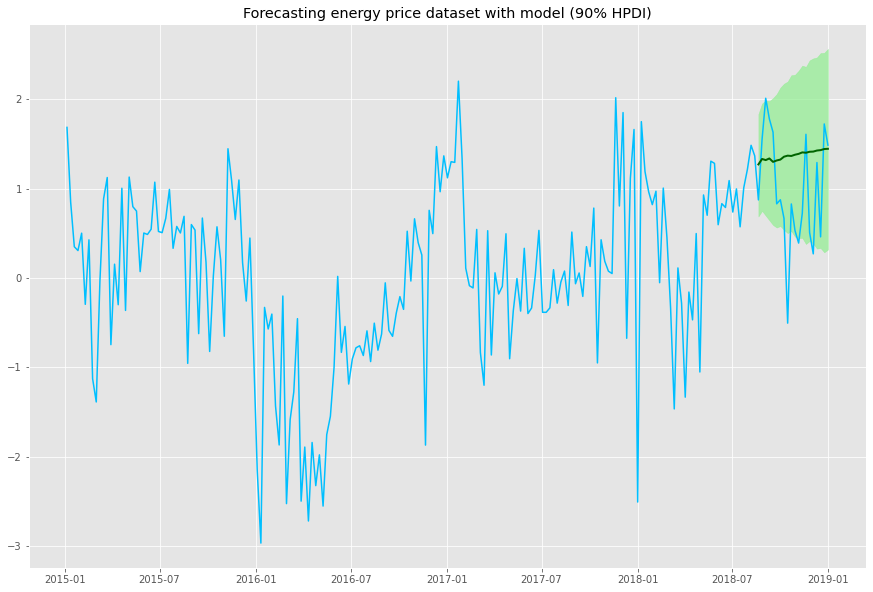

In [273]:
plt.figure(figsize=(15, 10))
plt.plot(dates, y.numpy().flatten(), 'deepskyblue')
t_future = dates[T1:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2, color='darkgreen')
plt.fill_between(t_future, hpd_low.flatten(), hpd_high.flatten(), alpha=0.7, color='lightgreen')
plt.title("Forecasting energy price dataset with model (90% HPDI)")
plt.show()